# HR Analytics – Employee Attrition & Workforce Insights

<font size="4">This project analyzes employee attrition using HR data to identify key risk drivers and provide actionable insights to support data-driven HR decision-making.
</font>

<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 1px 0;
"></div>


## 🔎 Data Quality & Preparation

The dataset was examined for missing values and inconsistencies prior to analysis.  
No null values were found, and all features were suitable for analysis without additional filtering or imputation.  
Outlier treatment was not applied, as variations in salary and tenure reflect legitimate role-based differences rather than data quality issues.


## 🧪 Data Source & Setup

<details>
<summary>🔧 Database Connection & Data Loading (click to expand)</summary>

This section covers:
- Installing required dependencies
- Secure database connection using Kaggle Secrets
- One-time data ingestion into PostgreSQL (Supabase)

</details>


In [2]:
!pip install psycopg2-binary

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
Db_url = user_secrets.get_secret("DATABASE_URL")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 5.8 MB/s eta 0:00:0000:0100:01


In [3]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine(Db_url)

try:
    connection = engine.connect()
    print("Connection successful via Supabase Pooler!")
    connection.close()
except Exception as e:
    print(f"Connection Failed: {e}")

Connection successful via Supabase Pooler!


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 1px 0;
"></div>

## 🔧 Data Ingestion & Database Setup



In [16]:
#Creating a dataframe of ibm_hr_dataset

df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

print("No.of rows and coloumns:",df.shape)


No.of rows and coloumns: (1470, 35)


In [5]:
# insertion of data to database(PostgreSQL[Supabase])
df.to_sql(
    "ibm_hr_attrition",
    engine,
    if_exists="replace", 
    index=False,
    method="multi",
    chunksize=500
)

print("Table created and data inserted successfully.")


Table created and data inserted successfully.


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 24px 0;
"></div>

## 🏢 Attrition Count & Rate

In [6]:
#Attrition Count & Rate
query = """
    SELECT 
    SUM(CASE WHEN "Attrition" = 'Yes' THEN 1 ELSE 0 END) AS attrition_count,
    ROUND(
            SUM(CASE WHEN "Attrition" = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*),2
         )  AS attrition_rate_percent
    FROM ibm_hr_attrition;
"""

df_overall = pd.read_sql(query, engine)
df_overall.style.hide(axis='index')

attrition_count,attrition_rate_percent
237,16.120000


## 🔍 Insight: Overall Attrition Level

The organization has a total of __237 employee exits__, resulting in an __overall attrition rate of 16.12%__.  
This indicates a __moderate but actionable level of employee turnover__, suggesting that targeted retention strategies are required rather than organization-wide interventions.


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 1px 0;
"></div>

##  🏢 Attrition rate by "Department"

In [13]:
#Attrition Rate by Department

query = """
       SELECT "Department",
       COUNT(*) AS total,
       SUM(CASE WHEN "Attrition"='Yes' THEN 1 ELSE 0 END) AS attrition_count,
       ROUND(
            SUM(CASE WHEN "Attrition"='Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*),2
            
       ) AS attrition_rate_percent
      FROM ibm_hr_attrition
      GROUP BY "Department"
      ORDER BY attrition_rate_percent DESC;
"""

df_department = pd.read_sql(query, engine)

df_department.style.hide(axis='index')


Department,total,attrition_count,attrition_rate_percent
Sales,446,92,20.630000
Human Resources,63,12,19.050000
Research & Development,961,133,13.840000


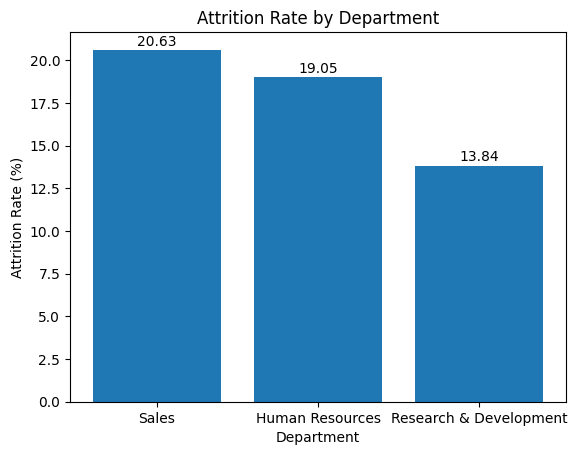

In [8]:
import matplotlib.pyplot as plt
plt.figure()
bar=plt.bar(
            df_department["Department"],
            df_department["attrition_rate_percent"]
           )

plt.xlabel("Department")
plt.ylabel("Attrition Rate (%)")
plt.title("Attrition Rate by Department")
plt.bar_label(bar,padding=1)
plt.show()


## 🔍 Insight: Attrition by Department

 Attrition rates vary across departments, with __Sales (20.63%)__ and __Human Resources (19.05%)__ experiencing higher attrition than __Research & Development (13.84%)__. This indicates department-specific challenges rather than a company-wide attrition issue.


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 1px 0;
"></div>

## 🏢 Attrition rate by "JobRole"

In [9]:

query = """
        SELECT 
       "JobRole",
        COUNT(*) AS Total,
        
        SUM(CASE WHEN "Attrition" = 'Yes' THEN 1 ELSE 0 END) AS Attrition_count,
        
        ROUND( 
                SUM(CASE WHEN "Attrition" = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*),2
             )  AS Attrition_rate_percent ,
        
        ROUND(
                AVG("MonthlyIncome"),2
             )  AS Avg_Salary
        FROM ibm_hr_attrition
        GROUP BY "JobRole"
        ORDER BY Attrition_rate_percent DESC;
"""

df_JobRole = pd.read_sql(query, engine)

df_JobRole.style.hide(axis='index')

JobRole,total,attrition_count,attrition_rate_percent,avg_salary
Sales Representative,83,33,39.760000,2626.000000
Laboratory Technician,259,62,23.940000,3237.170000
Human Resources,52,12,23.080000,4235.750000
Sales Executive,326,57,17.480000,6924.280000
Research Scientist,292,47,16.100000,3239.970000
Manufacturing Director,145,10,6.900000,7295.140000
Healthcare Representative,131,9,6.870000,7528.760000
Manager,102,5,4.900000,17181.680000
Research Director,80,2,2.500000,16033.550000


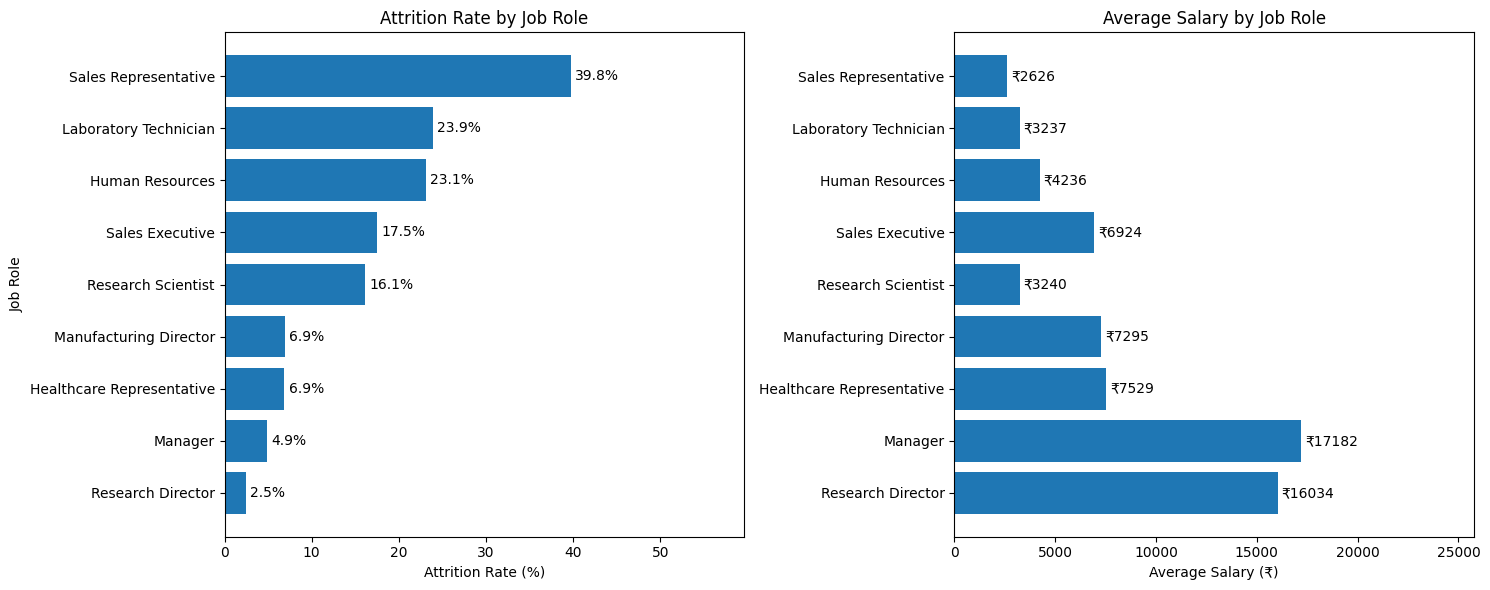

In [10]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

bars1 = ax1.barh(df_JobRole['JobRole'], df_JobRole['attrition_rate_percent'])
bars2 = ax2.barh(df_JobRole['JobRole'], df_JobRole['avg_salary'])

ax1.bar_label(bars1, padding=3, fmt='%.1f%%')
ax2.bar_label(bars2, padding=3, fmt='₹%.0f')

ax1.set_xlim(right=df_JobRole['attrition_rate_percent'].max() * 1.5)
ax2.set_xlim(right=df_JobRole['avg_salary'].max() * 1.5)


ax1.invert_yaxis()
ax2.invert_yaxis()


ax1.set_xlabel("Attrition Rate (%)")
ax1.set_ylabel("Job Role")
ax1.set_title("Attrition Rate by Job Role")

ax2.set_xlabel("Average Salary (₹)")
ax2.set_title("Average Salary by Job Role")


plt.tight_layout()
plt.show()

## 🔍Insight — High Attrition in Low-Paid Sales Roles

Sales Representatives experience the highest attrition rate __(~39.8%)__, significantly exceeding all other job roles, and this role also has one of the lowest average salaries. This suggests that the combination of high performance pressure, workload intensity, and comparatively lower compensation is a key driver of employee turnover in sales-facing positions.

<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 24px 0;
"></div>

## 🏢 Attrition rate by "OverTime" 

In [11]:
#Attrition rate by "OverTime"
query = """
        SELECT 
        "OverTime",
        COUNT(*) AS  total,
        SUM(CASE WHEN "Attrition"='Yes' THEN 1 ELSE 0 END) AS Attrition_count,
        ROUND(
                 SUM(CASE WHEN "Attrition"='Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*),2
              ) AS attrition_rate_percent
        FROM ibm_hr_attrition
        GROUP BY "OverTime"
        ORDER BY "OverTime";
"""

df_overtime = pd.read_sql(query, engine)
df_overtime.style.hide(axis="index")

OverTime,total,attrition_count,attrition_rate_percent
No,1054,110,10.440000
Yes,416,127,30.530000


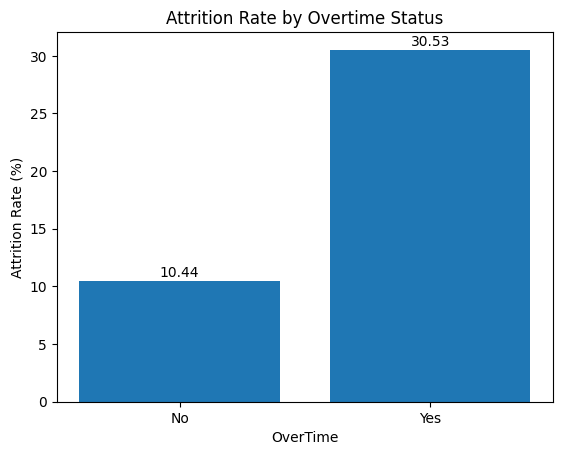

In [12]:
import matplotlib.pyplot as plt

plt.figure()
bar=plt.bar(
    df_overtime["OverTime"],
    df_overtime["attrition_rate_percent"]
)

plt.xlabel("OverTime")
plt.ylabel("Attrition Rate (%)")
plt.title("Attrition Rate by Overtime Status")

plt.bar_label(bar,padding=1)

plt.show()



## 🔍 Insight: Overtime vs Attrition

Employees working overtime show an attrition rate of __30.53%__, compared to __10.44%__ for employees not working overtime.  
This suggests that overtime is the strongest attrition driver and significantly increases the likelihood of employees leaving the organization.


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 24px 0;
"></div>


## 📌 Key Insights Summary

>- The overall attrition rate is __16.12%__, indicating a moderate but actionable level of employee turnover.
>- Employees working overtime are nearly __3× more likely to leave__ than those not working overtime.
>- Attrition is higher in __Sales and HR__, suggesting department-level risk factors.
>- Salary differences across job roles may influence retention when combined with workload pressures.


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 24px 0;
"></div>


## ✅ Recommendations
>- <font size="3"> Monitor and regulate overtime hours to reduce burnout-related attrition.</font>
>- <font size="3">Implement department-specific retention strategies, especially for Sales and HR.</font>
>  <font size="3">Improve work–life balance through flexible schedules and compensatory leave.</font>
>- <font size="3">Review compensation structures for lower-paying operational roles.</font>
>- <font size="3">Track attrition KPIs regularly to enable proactive HR planning.</font>


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 24px 0;
"></div>


## 🧾 Executive Summary

<font size="3">This project analyzed employee attrition using SQL and Python to identify key drivers impacting employee turnover.  
The analysis revealed overtime as the most significant contributor to attrition, with department-level variations also playing a major role.  
Based on these insights, targeted HR strategies were recommended to improve employee retention and workforce stability.
</font>


<div style="
    height: 8px;
    background: linear-gradient(to right, #7b2ff7, #3f51f5, #2196f3);
    border-radius: 4px;
    margin: 24px 0;
"></div>